In [4]:
# generic imports
import numpy as np
import pandas as pd
import cvxpy as cp
import math

In [12]:
# initial time step and final time under control
timeStep = 1
finalTime = 1000

# inital x sattelite (x,y,z,dx,dy,dz)
x_0 = np.array([0,0,0,100,0,0]).reshape((6,1))

# phi matrix given time and beginning time.
def phi(t_i,t_0, n=(2*np.pi) / 96400):
    t = t_i - t_0
    return np.array([[4 - 3*math.cos(n*t), 0, 0, (1/n) * math.sin(n*t), (2/n) * (1 - math.cos(n*t)),0],
                 [6*(math.sin(n*t)-n*t),1, 0, -1*(2/n)*( 1 - math.cos(n*t)), (1/n)*(4*math.sin(n*t) - 3*n*t),0],
                 [0,0,math.cos(n*t),0,0,(1/n)*math.sin(n*t)],
                 [3*n*math.sin(n*t),0,0,math.cos(n*t),2*math.sin(n*t),0],
                 [-6*n*(1-math.cos(n*t)),0,0,-2*math.sin(n*t), 4*math.cos(n*t)-3, 0], 
                 [0,0,-1*n*math.sin(n*t), 0, 0, math.cos(n*t)]])

# find the specific velocity pebetuation that we want for a given time step.
def delt(u,i,delta):
    return np.array([[0],[0],[0],[u[i][0]*delta],[u[i][1]*delta],[u[i][2]*delta]])

# move from x_0 to x_i
def move(x_0, u, target, delta):
    x_i = phi(target, 0) @ x_0
    for j in range(1, target):
        x_i = x_i + phi(target, j) @ delt(u,j,delta)

    return x_i

def moveOneStep(x_0, u, delta, i):
    x_i = x_0 + phi(1, 0) @ delt(u,i,delta)
    return x_i

In [13]:
# define u, the vector of movements as what we are trying to minimize.
from tabnanny import verbose


u = cp.Variable((finalTime*timeStep,3))
# define the objective function as the sum of the squares of the movements.
objective = cp.Minimize(cp.sum_squares(u))

# constraints for thie problem:
# 1. final position is (0,0,0) or very close to it.
# 2. the magnitude of every movement is less than maxPropulsion.
maxPropulsion = 100000
# 1. final position is (0,0,0) or very close to it.
constraints = [ np.sum(move(x_0, u, finalTime*timeStep, timeStep)**2) <= 0.1]

# 2. the magnitude of every movement is less than maxPropulsion.
for i in range(finalTime*timeStep):
    #if (i > finalTime*timeStep - 500):
    #    constraints.append(cp.norm(u[i,:]) <= 0.1)
    #else:
        constraints += [cp.norm(u[i,:]) <= maxPropulsion]


# solve the problem
prob = cp.Problem(objective, constraints)
sol = prob.solve(verbose=True)

print("Thrust Vectors at Final Time Step")
print(u.value)
print("Final Position")
print(move(x_0, u.value, finalTime*timeStep, timeStep))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 24 01:36:08 PM: Your problem has 3000 variables, 1001 constraints, and 0 parameters.
(CVXPY) Oct 24 01:36:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 24 01:36:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 24 01:36:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 24 01:36:09 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 24 01:36:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

Final Position
(0.31650605398763687, -0.020621709668503768, 0.0)


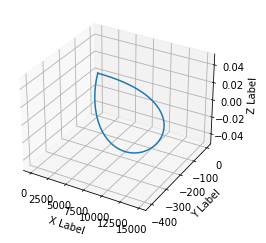

Text(0.5, 0, 'time')

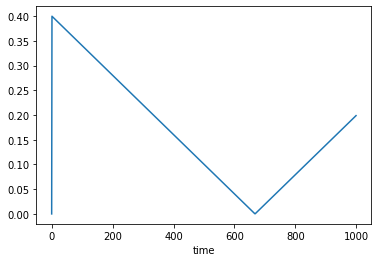

In [14]:
# plot trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_trajectory = [x_0[0][0]]
y_trajectory = [x_0[1][0]]
z_trajectory = [x_0[2][0]]

x_i = x_0
# get x,y,z values for plotting
for i in range(1,finalTime*timeStep):
    x_i = move(x_0, u.value, i, timeStep)
    # get first three elements of x_i
    x_trajectory.append(x_i[0][0])
    y_trajectory.append(x_i[1][0])
    z_trajectory.append(x_i[2][0])

print("Final Position")
print((x_trajectory[-1], y_trajectory[-1], z_trajectory[-1]))
#print(x_trajectory)
# print sizes

# plot trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x_trajectory, y_trajectory, z_trajectory)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# plot usage of thrust magnitude at each time step
thrust = [ math.sqrt(u.value[i][0]**2 + u.value[i][1]**2 + u.value[i][2]**2) for i in range(finalTime*timeStep)]

plt.plot(thrust)
plt.xlabel('time')